<a href="https://colab.research.google.com/github/mrSaggio/NEIRO/blob/main/my_classificator_densenet_num_mks5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os


!nvidia-smi

# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
# os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"

import tensorflow as tf
a = tf.zeros([], tf.float32)
print(1)


Wed Jun  5 09:40:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка библиотек

In [ ]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow import keras
from keras.utils import Progbar
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras import backend as K
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
import cv2


import tensorflow as tf

Выбор начальных параметров

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
batch_size = 32
dim=(224,224)

Выбор путей к файлам

In [ ]:
import pathlib
DATA_PATH = '/content/drive/MyDrive/NEIRO_KLEIMO_DIGITS/new_kleimo'
DATA_PATH = pathlib.Path(DATA_PATH)
data_ids = next(os.walk(DATA_PATH))[1]
print(data_ids)
image_count = len(list(DATA_PATH.glob('*/*.jpg')))
print(image_count)
Nonmetal = list(DATA_PATH.glob('0/*'))
PIL.Image.open(str(Nonmetal[0]))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'symbol']
508


Подготовка данных, включающая формирование черно-белых изображений

/content/drive/MyDrive/NEIRO_KLEIMO_DIGITS/new_kleimo/0/
Folder /content/drive/MyDrive/NEIRO_KLEIMO_DIGITS/new_kleimo_prep/0/ created!
ok
(62, 25, 3)
ok
(62, 25, 3)
ok
(62, 25, 3)
ok
(63, 25, 3)
ok
(63, 25, 3)
ok
(63, 25, 3)
ok
(61, 23, 3)
ok
(61, 24, 3)
ok
(61, 24, 3)
ok
(63, 24, 3)
ok
(63, 25, 3)
ok
(63, 25, 3)
ok
(63, 28, 3)
ok
(63, 28, 3)
ok
(63, 28, 3)
ok
(63, 28, 3)
ok
(63, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 28, 3)
ok
(66, 29, 3)
ok
(67, 29, 3)
ok
(67, 29, 3)
ok
(67, 29, 3)
ok
(67, 29, 3)
ok
(69, 29, 3)
ok
(69, 29, 3)
ok
(69, 29, 3)
ok
(69, 29, 3)
ok
(69, 29, 3)
ok
(69, 29, 3)
ok
(69, 29, 3)
ok
(69, 30, 3)
ok
(69, 30, 3)
ok
(62, 25, 3)
ok
(62, 25, 3)
ok
(62, 25, 3)
ok
(62, 25, 3)
ok
(62, 25, 3)
ok
(61, 23, 3)
ok
(63, 25, 3)
ok
(63, 28, 3)
ok
(61, 24, 3)
ok
(67, 29, 3)
ok
(69, 29, 3)
ok
(63, 28, 3)
ok
(61, 24, 3)
ok
(61, 24, 3)
ok
(67, 29, 3)
ok
(69, 29

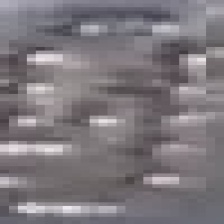

In [ ]:

def preparing(dir_number):
    destination_path = str(DATA_PATH) +'/' +str(data_ids[dir_number])+'/'
    target_path = str(DATA_PATH) +'_prep/'+str(data_ids[dir_number])+'/'
    print(destination_path)
    try:
        os.makedirs(target_path)
        print("Folder %s created!" % target_path)
    except FileExistsError:
        print("Folder %s already exists" % target_path)

    format_of_your_images = 'jpg'
    all_the_files = Path(destination_path).rglob(f'*.{format_of_your_images}')
    n=0
    for f in all_the_files:
        n+=1
        print("ok")
        p = cv2.imread(str(f))
        # hsv = cv2.cvtColor(p,cv2.COLOR_BGR2HSV)
        # h_min = np.array((0, 78, 166), np.uint8)
        # h_max = np.array((93, 255, 255), np.uint8)
        # mask = cv2.inRange(hsv, h_min, h_max)
        # imgSer = cv2.bitwise_and(p, p, mask=mask)

        # gray = cv2.cvtColor(imgSer, cv2.COLOR_BGR2GRAY)
        # thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)[1]
        # p = cv2.merge([thresh, thresh, thresh])
        # p=p[340:-100,60:-300]
        print(p.shape)
        p = cv2.resize(p, dim, interpolation = cv2.INTER_AREA)
        cv2.imwrite(f'{target_path}/{data_ids[dir_number]}{n}.{format_of_your_images}', p)
        # cv2.imwrite('target_path/'+str(data_ids[dir_number]) +str(n)+'.'+ format_of_your_images, p)

for i in range(len(data_ids)):
    preparing(i)

IMG_WIDTH =dim[0]
IMG_HEIGHT=dim[1]

data_path_prep = str(DATA_PATH) +'_prep/'

DATA_PATH_P = pathlib.Path(data_path_prep)
digit = list(DATA_PATH_P.glob('0/*'))
PIL.Image.open(str(digit[0]))


Чтение изображений и меток в тренировочном наборе

In [ ]:
# Function read train images and mask return as nump array
IMG_WIDTH =dim[0]
IMG_HEIGHT=dim[1]
def read_train_data(IMG_WIDTH=IMG_WIDTH,IMG_HEIGHT=IMG_HEIGHT,IMG_CHANNELS=3):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path_prep,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size)
    class_names = train_ds.class_names
    print(class_names)
    return train_ds
train_ds = read_train_data()

Found 508 files belonging to 11 classes.
Using 407 files for training.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'symbol']


In [ ]:
# Function to read test images and return as numpy array
def read_val_data(IMG_WIDTH=IMG_WIDTH,IMG_HEIGHT=IMG_HEIGHT,IMG_CHANNELS=3):
    val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path_prep,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size)
    class_names = val_ds.class_names
    print(class_names)
    return val_ds
val_ds = read_val_data()

Found 508 files belonging to 11 classes.
Using 101 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'symbol']


In [ ]:
class_names = train_ds.class_names
print(class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'symbol']


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



0.2901961 0.9843138


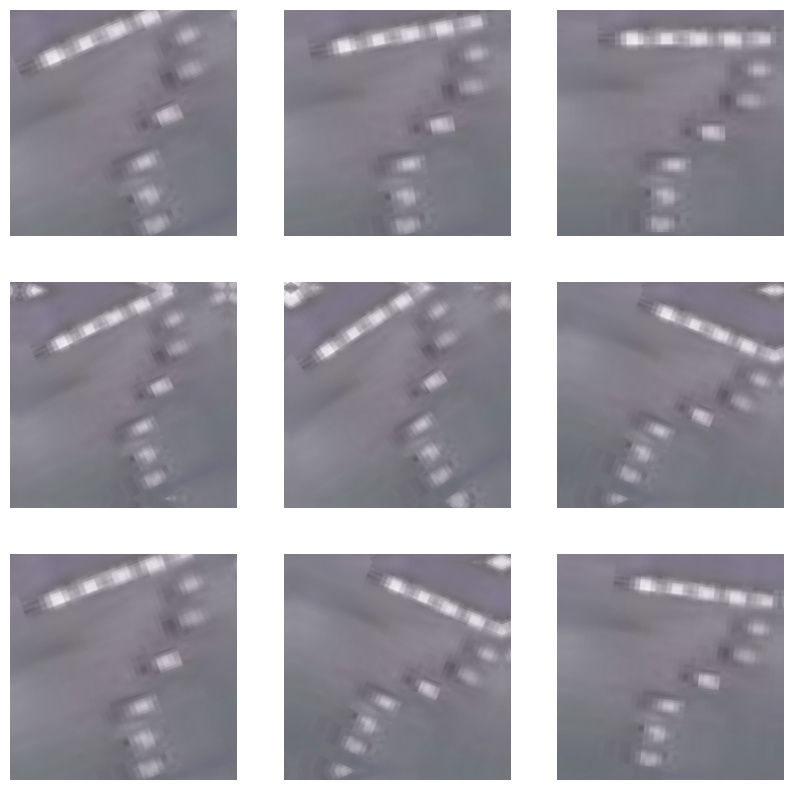

In [ ]:
data_augmentation = keras.Sequential(
[    layers.RandomRotation(0.1,
                    input_shape=(IMG_WIDTH,
                                IMG_HEIGHT,
                                3)),

    layers.RandomZoom(0.1),
]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# from keras.src.applications.mobilenet import MobileNet
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D

# # create the base pre-trained model
# base_model = MobileNet(weights='imagenet', include_top=False)

# base_model=Sequential([
#     data_augmentation,
#     base_model
# ])

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer -- let's say we have 200 classes
# predictions = Dense(11, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)



In [ ]:
from keras.src.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

base_model=Sequential([
    data_augmentation,
    base_model
])

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(11, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)




29084464/29084464 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_input (InputLay  [(None, 224, 224, 3)]     0         
 er)                                                             
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                             

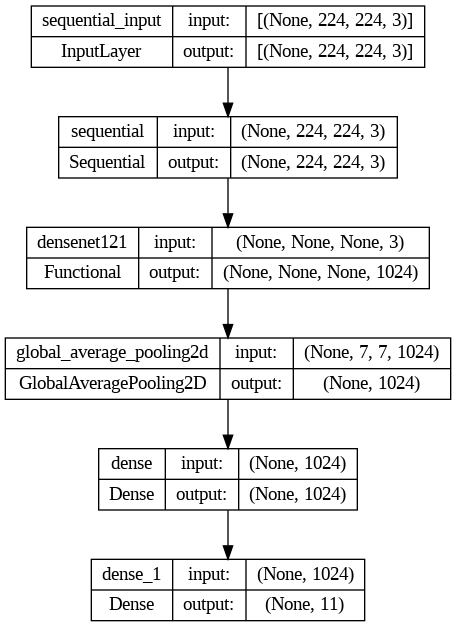

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
my_net = model
my_net.summary()
tf.keras.utils.plot_model(my_net, show_shapes=True)

In [ ]:
my_net.save(f'{current_datetime}densenet.keras')

NameError: name 'current_datetime' is not defined

In [ ]:
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d")

print("\nTraining...")
epochs = 200
history = my_net.fit(train_ds,validation_data=val_ds,epochs=epochs)

my_net.save(f'my_model{current_datetime}densenet.h5')


Training...
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 63s 1s/step - loss: 1.8987 - accuracy: 0.4103 - val_loss: 2.3298 - val_accuracy: 0.1386
Epoch 2/200
13/13 [==============================] - 5s 364ms/step - loss: 1.2045 - accuracy: 0.6265 - val_loss: 2.3576 - val_accuracy: 0.1386
Epoch 3/200
13/13 [==============================] - 5s 365ms/step - loss: 0.9063 - accuracy: 0.7396 - val_loss: 2.3490 - val_accuracy: 0.1386
Epoch 4/200
13/13 [==============================] - 5s 361ms/step - loss: 0.7078 - accuracy: 0.7912 - val_loss: 2.4040 - val_accuracy: 0.1386
Epoch 5/200
13/13 [==============================] - 5s 369ms/step - loss: 0.5328 - accuracy: 0.8673 - val_loss: 2.5022 - val_accuracy: 0.1485
Epoch 6/200
13/13 [==============================] - 5s 368ms/step - loss: 0.3959 - accuracy: 0.9189 - val_loss: 2.5688 - val_accuracy: 0.1485
Epoch 7/200
13/13 [==============================] - 5s 365ms/step - loss: 0.3250 - accuracy: 0.9238 - val_loss: 2.4332 - val_accuracy: 0.1683
Epoch 8/200
1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


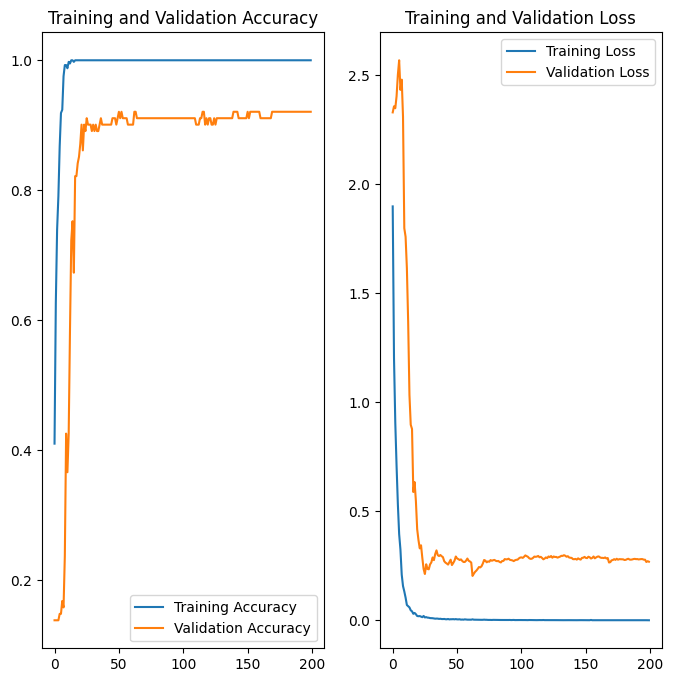

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predict_path = "predict_dir"



def preparing_predict():
    destination_path = str(predict_path) +'/'
    target_path = str(predict_path) +'_prep/'
    print(destination_path)
    try:
        os.makedirs(target_path)
        print("Folder %s created!" % target_path)
    except FileExistsError:
        print("Folder %s already exists" % target_path)

    format_of_your_images = 'jpg'
    all_the_files = Path(destination_path).rglob(f'*.{format_of_your_images}')
    n=0
    for f in all_the_files:
        n+=1
        print("ok")
        p = cv2.imread(str(f))
        print(p.shape)
        p = cv2.resize(p, dim, interpolation = cv2.INTER_AREA)
        cv2.imwrite(f'{target_path}/predict{f.name}', p)
        # cv2.imwrite('target_path/'+str(data_ids[dir_number]) +str(n)+'.'+ format_of_your_images, p)
    return target_path

target_predict_path=preparing_predict()

print(target_predict_path)
target_predict_path = pathlib.Path(target_predict_path)
pred = list(target_predict_path.glob('*'))





predict_dir/
Folder predict_dir_prep/ created!
predict_dir_prep/


In [ ]:
def display(img_list,img_name_list,class_and_confidence):
    plt.figure(figsize=(20, 20))
    for i in range(len(img_list)):
        img=img_list[i]
        plt.subplot(1,len(img_list), i + 1)
        plt.title(img_name_list[i]+'\n'+class_and_confidence[i])
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis("off")

In [ ]:
img_list =[]
name_list = [os.path.basename(x) for x in pred]
class_and_confidence=[]
print(name_list)
for i in range(len(pred)):
    img = tf.keras.utils.load_img(str(pred[i]))
    print(type(img))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = my_net.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    img_list.append(PIL.Image.open(str(pred[i])))
    class_and_confidence.append(str(class_names[np.argmax(score)]))

display(img_list,name_list,class_and_confidence)

[]


<Figure size 2000x2000 with 0 Axes>

In [ ]:
# new_model = tf.keras.models.load_model(f'my_model{current_datetime}.h5')
new_model = tf.keras.models.load_model('/content/my_model2024-06-05densenet.h5')

# Show the model architecture
new_model.summary()

# loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_input (InputLay  [(None, 224, 224, 3)]     0         
 er)                                                             
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                             

In [ ]:
tf.saved_model.save(new_model,"")

In [ ]:
img_list =[]
name_list = [os.path.basename(x) for x in pred]
class_and_confidence=[]
print(name_list)
for i in range(len(pred)):
    img = tf.keras.utils.load_img(str(pred[i]))
    print(type(img))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    img_list.append(PIL.Image.open(str(pred[i])))
    class_and_confidence.append(str(class_names[np.argmax(score)]))

display(img_list,name_list,class_and_confidence)

[]


<Figure size 2000x2000 with 0 Axes>

In [ ]:
!kill -9 330229

/bin/bash: line 1: kill: (330229) - No such process


In [ ]:
!zip -r /content/variables.zip /content/variables

  adding: content/variables/ (stored 0%)
  adding: content/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/variables/variables.index (deflated 78%)


In [ ]:
!zip -r /content/sample_data.zip /content/sample_data

  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/anscombe.json (deflated 83%)
  adding: content/sample_data/README.md (deflated 42%)
  adding: content/sample_data/california_housing_train.csv (deflated 79%)
  adding: content/sample_data/mnist_test.csv (deflated 88%)
  adding: content/sample_data/california_housing_test.csv (deflated 76%)
  adding: content/sample_data/mnist_train_small.csv (deflated 88%)


In [ ]:
!zip -r /content/predict_dir_prep.zip /content/predict_dir_prep

  adding: content/predict_dir_prep/ (stored 0%)


In [ ]:
!zip -r /content/predict_dir_prep.zip /content/predict_dir_prep